In [1]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange

In [2]:
#path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#/Ti scope/2023_11_28/2023_11_28_10x_1.0x_pAAA_Ti_Pos6.ome.tif

In [3]:
scope_name = 'Tweez scope'
#scope_name = 'Ti scope'
path_scope = os.path.join(path_ext, scope_name)
exp_date = '2023_12_04'
path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
vector = 'pLPT107&pLPT41'
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [4]:
exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
i = exp_sum[(exp_sum.formatted_dates == exp_date) & (exp_sum.Machine == scope_name)].index[0]

In [5]:
exp_sum

,Date,Machine,Strain,DNA,Chemical,Dilution,formatted_dates
0,2023-11-15,Ti scope,MC4100 & DHL708,pLPT20&pLPT41,-,10^(-5),2023_11_15
1,2023-11-15,Tweez scope,MC4100 & DHL708,pLPT20&pLPT41,-,10^(-6),2023_11_15
2,2023-11-17,Ti scope,DHL708,pLPT119&pLPT41,-,10^(-5),2023_11_17
3,2023-11-17,Tweez scope,MC4100 & DHL708,pLPT119&pLPT41,-,10^(-6),2023_11_17
4,2023-11-28,Ti scope,MC4100 & MG1655,pAAA,-,10^(-6),2023_11_28
5,2023-11-28,Tweez scope,MG1655,pAAA,-,10^(-5),2023_11_28
6,2023-11-30,Ti scope,MC4100,pAAA,-,10^(-6),2023_11_30
7,2023-11-30,Tweez scope,MC4100,pAAA,-,10^(-5),2023_11_30
8,2023-12-04,Ti scope,MC4100,pLPT107&pLPT41,IPTG,10^(-6),2023_12_04
9,2023-12-04,Tweez scope,MC4100,pLPT107&pLPT41,IPTG,10^(-5),2023_12_04


In [7]:
positions = pd.read_excel('../Notebooks/Positions.xlsx')
df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')]
df_pos.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,Quality,exp length,Colonies,Centers,Radius,radj
136,2023-12-04,Tweez scope,0,MC4100,pLPT107&pLPT41,IPTG-,1,10^(-5),11:45:00,17:11:00,Very good,216,1.0,"750, 640",100.0,30.0
142,2023-12-04,Tweez scope,6,MC4100,pLPT107&pLPT41,IPTG-,1,10^(-5),11:45:00,17:11:00,Very good,216,1.0,"510, 510",100.0,50.0
143,2023-12-04,Tweez scope,7,MC4100,pLPT107&pLPT41,IPTG-,1,10^(-5),11:45:00,17:11:00,Very good,216,1.0,"515, 515",70.0,20.0
144,2023-12-04,Tweez scope,8,MC4100,pLPT107&pLPT41,IPTG-,1,10^(-5),11:45:00,17:11:00,Very good,216,1.0,"510, 515",70.0,30.0
145,2023-12-04,Tweez scope,9,MC4100,pLPT107&pLPT41,IPTG-,1,10^(-5),11:45:00,17:11:00,Very good,216,1.0,"510, 510",70.0,30.0


In [8]:
pos = 0
fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
path_im = os.path.join(path_ext,scope_name,exp_date,fname)
path_edt = os.path.join(path_ext,scope_name,exp_date,folder_results,f'pos{pos}','edt.npy')
im_all = imread(path_im)
im_fluo = im_all[:,:,:,:ph_chn]
edt = np.load(path_edt)
nt, nx ,ny, nc = im_fluo.shape
fname

'2023_12_04_10x_1.0x_pLPT107&41_TiTweez_Pos0.ome.tif'

In [9]:
bg = np.zeros(nc)
for c in range(nc):
    bg[c] = im_all[0,:100,:100,c].mean(axis=(0,1))
bg

array([229.2884, 193.7722, 220.5398])

In [19]:
for pos in [0]:#poss:
    fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
    path_im = os.path.join(path_ext,scope_name,exp_date,fname)
    path_edt = os.path.join(path_ext,scope_name,exp_date,folder_results,f'pos{pos}','edt.npy')
    im_all = imread(path_im)
    im_fluo = im_all[:,:,:,:ph_chn]
    edt = np.load(path_edt)
    nt, nx ,ny, nc = im_fluo.shape
    bg = np.zeros(nc)
    for c in range(nc):
        bg[c] = im_all[0,:100,:100,c].mean(axis=(0,1))

    chns = np.arange(nc)
    mean = np.zeros((nt,nc))
    rho = np.zeros((nt,nc))
    lrho = np.zeros((nt,nc))
    dlrho = np.zeros((nt,nc))
    
    for t in range(nt):
        tedt = edt[t,:,:]
        idx = tedt > 0
        for ch in chns:
            mean[t, ch] = np.nanmean(im_fluo[t, idx, ch] - bg[ch])
    
    if fluo_chns == 2:
        rho[:,0] = mean[:, 0] / mean[:, 1]
        rho[:,1] = mean[:, 1] / mean[:, 0]
        
    elif fluo_chns == 3:
        rho[:,0] = mean[:, 0] / mean[:, 1]
        rho[:,1] = mean[:, 0] / mean[:, 2]
        rho[:,2] = mean[:, 1] / mean[:, 2]
    
    lrho = np.log(rho)
    for c in range(2):
        idx = ~np.isnan(lrho[:,c])
        dlrho[idx,c] = savgol_filter(lrho[idx,c], 21, 3, deriv=1, axis=0)

    
    
    #np.save(os.path.join(path_results, 'mean_fluo_colony_ts.npy'), mean)
    #np.save(os.path.join(path_results, 'mean_fluo_colony.npy'), mean.mean(axis=0))
    #np.save(os.path.join(path_results, 'mean_rho_colony_ts.npy'), rho)
    #np.save(os.path.join(path_results, 'mean_rho_colony.npy'), rho.mean(axis=0))
    #np.save(os.path.join(path_results, 'mean_lrho_colony_ts.npy'), lrho)
    #np.save(os.path.join(path_results, 'mean_lrho_colony.npy'), lrho.mean(axis=0))
    #np.save(os.path.join(path_results, 'mean_dlrho_colony_ts.npy'), dlrho)
    #np.save(os.path.join(path_results, 'mean_dlrho_colony.npy'), dlrho.mean(axis=0))

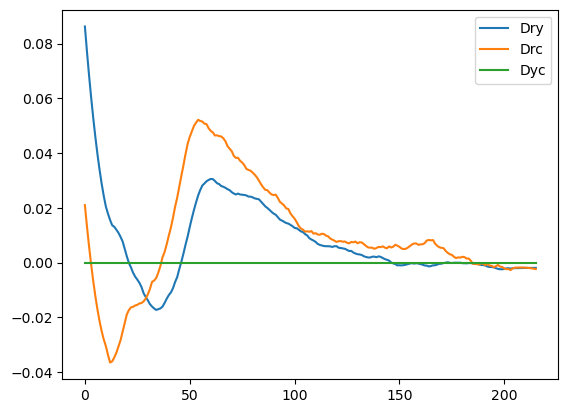

In [20]:
plt.plot(dlrho[:,0], label='Dry')
plt.plot(dlrho[:,1], label='Drc')
plt.plot(dlrho[:,2], label='Dyc')
plt.legend()
plt.show()

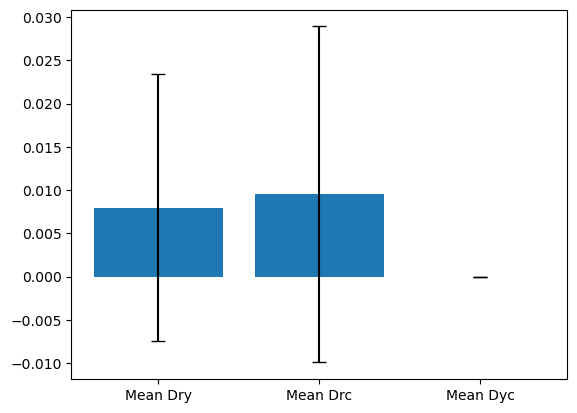

In [21]:
cats = ['Mean Dry', 'Mean Drc', 'Mean Dyc']
means = [dlrho[:,0].mean(), dlrho[:,1].mean(), dlrho[:,2].mean()]
errs = [dlrho[:,0].std(), dlrho[:,1].std(), dlrho[:,2].std()]
plt.bar(cats,means,yerr=errs, capsize=5)
plt.show()

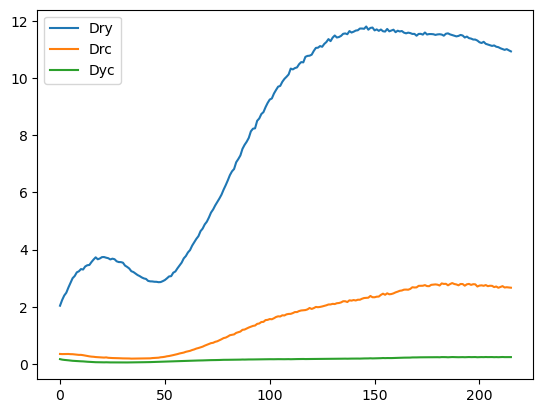

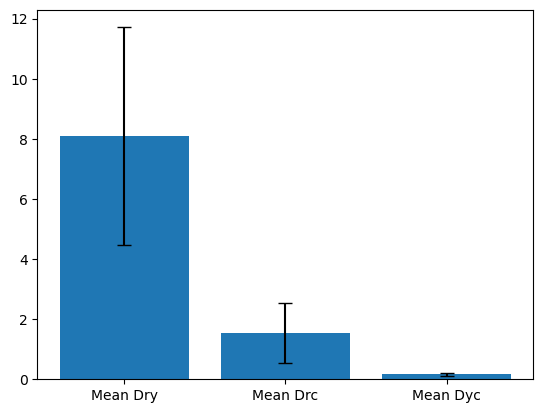

In [22]:
plt.plot(rho[:,0], label='Dry')
plt.plot(rho[:,1], label='Drc')
plt.plot(rho[:,2], label='Dyc')
plt.legend()
plt.show()

cats = ['Mean Dry', 'Mean Drc', 'Mean Dyc']
means = [rho[:,0].mean(), rho[:,1].mean(), rho[:,2].mean()]
errs = [rho[:,0].std(), rho[:,1].std(), rho[:,2].std()]
plt.bar(cats,means,yerr=errs, capsize=5)
plt.show()

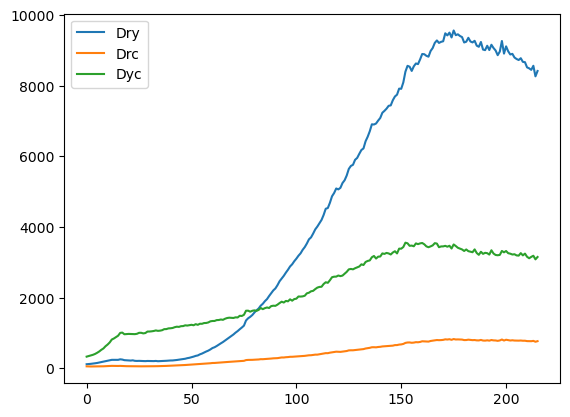

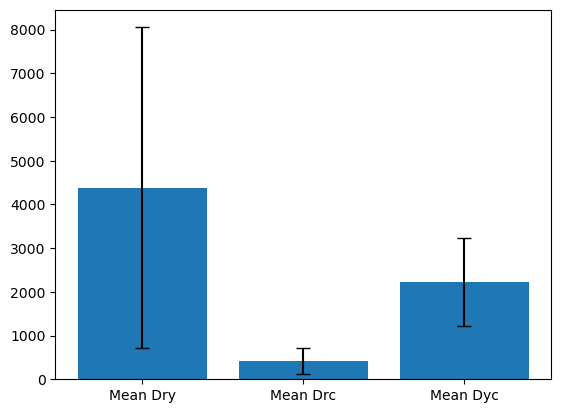

In [14]:
plt.plot(mean[:,0], label='Dry')
plt.plot(mean[:,1], label='Drc')
plt.plot(mean[:,2], label='Dyc')
plt.legend()
plt.show()

cats = ['Mean Dry', 'Mean Drc', 'Mean Dyc']
means = [mean[:,0].mean(), mean[:,1].mean(), mean[:,2].mean()]
errs = [mean[:,0].std(), mean[:,1].std(), mean[:,2].std()]
plt.bar(cats,means,yerr=errs, capsize=5)
plt.show()

In [15]:
lrho.mean(axis=0)

array([ 1.95709338,  0.05810616, -1.89898722])

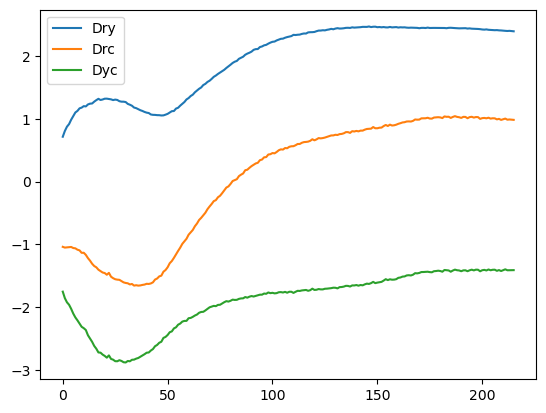

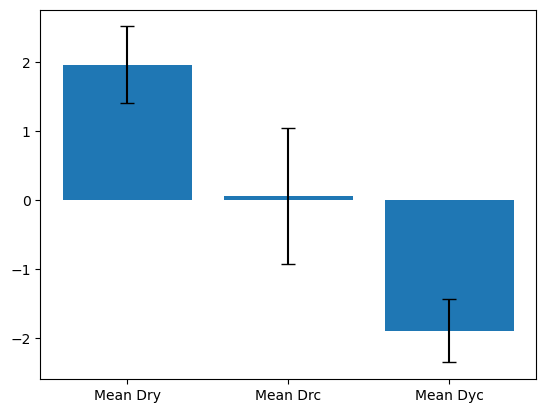

In [16]:
plt.plot(lrho[:,0], label='Dry')
plt.plot(lrho[:,1], label='Drc')
plt.plot(lrho[:,2], label='Dyc')
plt.legend()
plt.show()

cats = ['Mean Dry', 'Mean Drc', 'Mean Dyc']
means = [lrho[:,0].mean(), lrho[:,1].mean(), lrho[:,2].mean()]
errs = [lrho[:,0].std(), lrho[:,1].std(), lrho[:,2].std()]
plt.bar(cats,means,yerr=errs, capsize=5)
plt.show()

In [25]:
path = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Tweez scope/2023_11_15/results/pos0'
os.listdir(path)

['radius.npy',
 'area.npy',
 'vfront.npy',
 'expansion_rate.npy',
 'edt.npy',
 'kymo.npy',
 'dlkymo_rho.npy',
 'wdlkymo_rho.npy',
 'radpos.npy',
 'vmag.npy',
 'vrad.npy',
 'vtheta.npy',
 'cov.npy',
 'corr.npy',
 'mean.npy',
 'corr_map.npy',
 'mean_map.npy',
 'r0.npy',
 'mu0.npy',
 'x_model.npy',
 'x_data.npy',
 'y_model.npy',
 'y_data.npy',
 'svmag.npy',
 'mean_fluo_colony_ts.npy',
 'mean_fluo_colony.npy',
 'mean_rho_colony_ts.npy',
 'mean_rho_colony.npy',
 'mean_lrho_colony_ts.npy',
 'mean_lrho_colony.npy',
 'mean_dlrho_colony_ts.npy',
 'mean_dlrho_colony.npy']

In [34]:
radpos = np.load(path+'/'+'svmag.npy')

In [35]:
radpos.shape

(60, 32, 32)